# Illustrates the use of the WR (Weather Regime) class

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
import sys
sys.path.insert(0, '../')

In [3]:
from paleopy import proxy
from paleopy import analogs
from paleopy import ensemble
from paleopy import WR
from paleopy.plotting import scalar_plot

In [4]:
proxies_num = pd.read_excel('../data/ProxiesLIANZSWP.xlsx', sheetname='numerical')

In [5]:
row = proxies_num.iloc[0,]

In [6]:
row

Site        Rarotonga
Lat            -21.23
Long          -159.82
Anom              0.6
dataset         ersst
variable          sst
Name: 0, dtype: object

In [7]:
djsons = '../jsons/'
pjsons = '../jsons/proxies'

In [8]:
p = proxy(sitename = row.Site,\
          lon = row.Long,\
          lat = row.Lat,\
          djsons = djsons,\
          pjsons = pjsons,\
          dataset = row.dataset,\
          variable = row.variable,\
          season = 'DJF',\
          value = row.Anom, \
          calc_anoms = False,\
          detrend=True)

In [9]:
p.season

'DJF'

In [10]:
# extract the time-series
p.extract_ts()

print("{}{} --> {}{}: {} km".format(p.sitename, p.coords, p.variable, p.extracted_coords.tolist(), p.distance_point))

# calculates the season
p.calculate_season()

p.find_analogs()

Rarotonga(200.18000000000001, -21.23) --> sst[200.0, -22.0]: 87.56368858840081 km


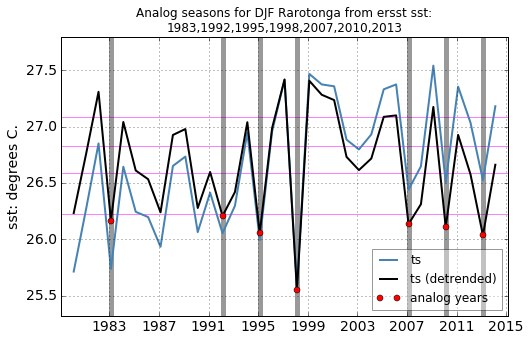

In [11]:
f = p.plot_season_ts()

In [12]:
from paleopy import WR

### try with a proxy object

In [13]:
w = WR(p, classification='SW Pacific Regimes')

In [14]:
obs_probs = w._get_compos_probs(w.analog_years)

In [15]:
w.probs_anomalies()

In [16]:
w.df_probs

,Rarotonga,10,90,5,95,1,99
SW1,0.305864,0.186091,0.226634,0.179576,0.232346,0.171953,0.240352
SW2,0.083994,0.105464,0.136072,0.101242,0.140256,0.093993,0.151326
SW3,0.160063,0.143294,0.181123,0.138326,0.186473,0.129920,0.197554
SW4,0.129952,0.137142,0.170424,0.131830,0.176538,0.123416,0.185716
SW5,0.126783,0.110050,0.139091,0.106209,0.144058,0.099347,0.153244
SW6,0.193344,0.210164,0.255636,0.203668,0.262151,0.191819,0.275888


that should fail with a size error exception, the heatmaps and bar plots will
only work if an ensemble object is passed

In [17]:
w.plot_bar()


        not enough proxies in the ensemble, size was 1
        need at list 5
        


Exception: size error

The following should work

### try with passing an `ensemble` object 

In [18]:
ens = ensemble(djsons=djsons, pjsons=pjsons, season='DJF')

In [19]:
# classification = 'SW Pacific Regimes'
classification = 'Kidson Types'

In [20]:
w = WR(ens, classification=classification)

In [21]:
w.parent.description

'ensemble'

In [22]:
w.climatology

[1981, 2010]

In [23]:
w.probs_anomalies(kind='many')

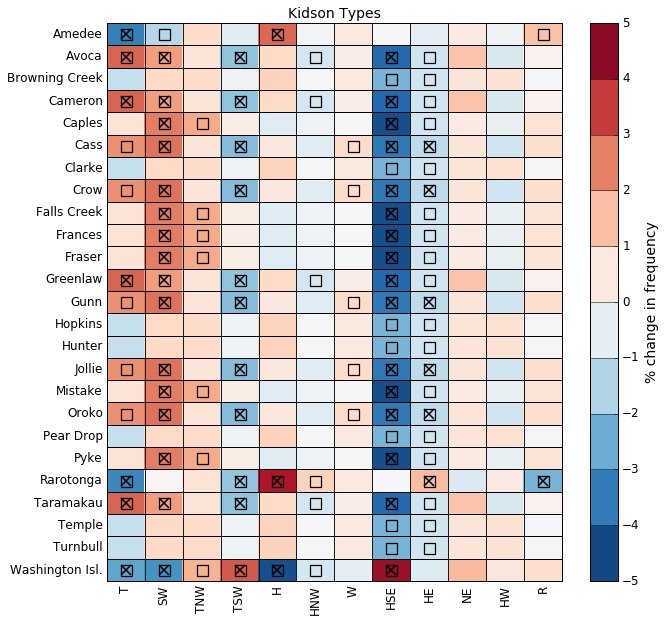

In [24]:
f = w.plot_heatmap()

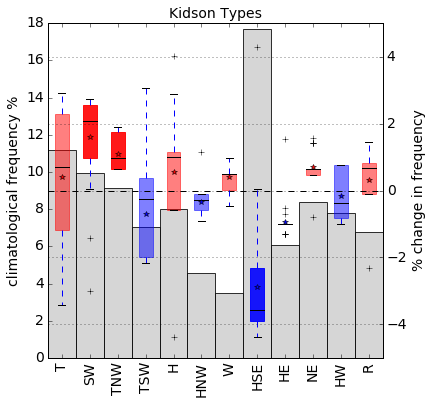

In [33]:
f = w.plot_bar()